# DeLDRify - ESRGAN applied to single-track LDR to HDR image conversion

## Import and initalize the models

In [2]:
import torch

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

In [3]:
from generator import RRDBNet
from discriminator import DiscriminatorForVGG

G = RRDBNet(in_nc=3, out_nc=4, nf=64, nb=8, gc=32)
D = DiscriminatorForVGG(in_channels=4, out_channels=4, channels=64)

G.to(device=device)
D.to(device=device);

In [4]:
print("Number of param (G):", sum(p.numel() for p in G.parameters()) / 1_000_000, "M")
print("Number of param (D):", sum(p.numel() for p in D.parameters()) / 1_000_000, "M")

Number of param (G): 5.79642 M
Number of param (D): 14.50028 M


## Prepare the data

In [5]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((128, 128), antialias=None), 
])

In [6]:
from custom_datasets import PairWiseImages, PairWiseImagesRGBE

### Original dataset RGB format
# pair = PairWiseImages("LDR-HDR-pair_Dataset-master/LDR_exposure_0/", 
#                       "LDR-HDR-pair_Dataset-master/HDR/", 
#                       transform=train_transform)

### RGBE format
pair = PairWiseImagesRGBE("LDR-HDR-pair_Dataset-master/LDR_exposure_0/", 
                      "LDR-HDR-pair_Dataset-master/HDR/", 
                      transform=train_transform, device=device)

In [7]:
import torch
from torch.utils.data import Subset

indices = torch.arange(40)
pair_40 = Subset(pair, indices)

In [8]:
import torch

length = len(pair_40)
test_length = int(0.2 * length)

train, valid = torch.utils.data.random_split(pair_40, [length - test_length, test_length])

In [9]:
BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=True)

## Train the models

In [ ]:
import wandb
wandb.login()

run = wandb.init(project="DeLDRify")

In [ ]:
criterion_pixel = torch.nn.L1Loss().to(device)
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)

In [ ]:
from datetime import datetime

results_dir = './cache-' + run.name
results_dir

In [ ]:
from tqdm.notebook import tqdm
import os
import numpy as np

epochs = 100

optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.9, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.9, 0.999))

loss_scaling_factor = 1e-3

if not os.path.exists(results_dir):
        os.mkdir(results_dir)

for epoch in tqdm(range(epochs)):
    total_loss_G = 0
    total_loss_D = 0
    total_loss_D_real = 0
    total_loss_D_fake = 0

    for ldr, hdr in tqdm(train_dataloader, leave=False):

        D_output_shape = D.out_channels

        valid = torch.tensor(np.ones((ldr.size(0), D_output_shape)), requires_grad=False, dtype=torch.float32).to(device=device)
        fake = torch.tensor(np.zeros((ldr.size(0), D_output_shape)), requires_grad=False, dtype=torch.float32).to(device=device)

        # Train Generator
        optimizer_G.zero_grad()

        fake_hdr = G(ldr)

        loss_pixel = criterion_pixel(fake_hdr, hdr)

        pred_real = D(hdr).detach()
        pred_fake = D(fake_hdr)

        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        loss_G = loss_pixel + loss_scaling_factor * loss_GAN
        total_loss_G += loss_G.item()

        loss_G.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        pred_real = D(hdr)
        pred_fake = D(fake_hdr.detach())

        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        loss_D = (loss_real + loss_fake) / 2
        total_loss_D_real += loss_real.item()
        total_loss_D_fake += loss_fake.item()
        total_loss_D += loss_D.item()

        loss_D.backward()
        optimizer_D.step()

    wandb.log({"loss_G": total_loss_G / len(train_dataloader), "loss_D": total_loss_D / len(train_dataloader), "loss_D_real": total_loss_D_real / len(train_dataloader), "loss_D_fake": total_loss_D_fake / len(train_dataloader), "epoch": epoch})

    torch.save(G.state_dict(), f"{results_dir}/generator_last.pth")
    torch.save(D.state_dict(), f"{results_dir}/discriminator_last.pth")

In [ ]:
wandb.finish()

## Load the model and do inference

[ WARN:0@16.867] global matrix_expressions.cpp:1334 assign OpenCV/MatExpr: processing of multi-channel arrays might be changed in the future: https://github.com/opencv/opencv/issues/16739


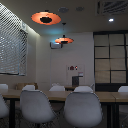

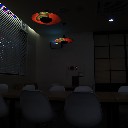

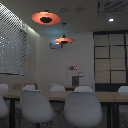

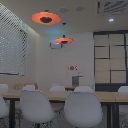

In [10]:
from utils import RGBE_to_RGB, preprocess_tensor_to_array
from utils import hdr_np_to_img_manual, hdr_np_to_img_tonemap, np_to_img_naive



# load data from train dataset onto cpu
ldr, hdr = train[0]
ldr = preprocess_tensor_to_array(ldr, RGBE=False)
hdr = preprocess_tensor_to_array(hdr, RGBE=True)

# convert from RGBE to RGB
hdr_RGB = RGBE_to_RGB(hdr.copy())

# create PIL images (naive approach)
ldr_img = np_to_img_naive(ldr)
hdr_img = np_to_img_naive(hdr_RGB)

# create PIL images (tonemap approach)
new_hdr_img = hdr_np_to_img_manual(hdr_RGB)
new_hdr2_img = hdr_np_to_img_tonemap(hdr_RGB)

# list of images to display
images = [ldr_img, hdr_img, new_hdr_img, new_hdr2_img]

# display images
display(*images)

In [ ]:
from generator import RRDBNet
from discriminator import DiscriminatorForVGG
import torch

# cache to read model weights from
target_dir = "cache-elated-rain-5"

# create models
G = RRDBNet(in_nc=3, out_nc=4, nf=64, nb=8, gc=32)
D = DiscriminatorForVGG(in_channels=4, out_channels=4, channels=64)

# load weights
G.load_state_dict(torch.load(f"{target_dir}/generator_last.pth"))
D.load_state_dict(torch.load(f"{target_dir}/discriminator_last.pth"))

# move models to device (cpu, cuda or mps)
G.to(device=device)
D.to(device=device);

In [ ]:
# load a batch from the validation dataset
ldr, hdr = next(iter(valid_data_loader))

# create a real, generated and random HDR image
real_hdr = hdr
fake_hdr = G(ldr)
random_hdr = torch.rand_like(hdr)

# run discriminator on the images
print("Real HDR images (values should be positive)")
print(D(hdr).mean(0, keepdim=True).detach())
print()

print("Random HDR images (values should be negative)")
print(D(random_hdr).mean(0, keepdim=True).detach())
print()

print("Generated HDR images (values should be positive for a good generator, and negative for a good discriminator)")
print(D(fake_hdr).mean(0, keepdim=True).detach())
print()

In [ ]:
from utils import RGB_to_RGBE
import cv2 as cv

hdr = cv.imread("LDR-HDR-pair_Dataset-master/HDR/HDR_001.hdr", flags=cv.IMREAD_ANYDEPTH)
hdr_RGBE = RGB_to_RGBE(hdr)

In [ ]:
import cv2 as cv
from utils import RGBE_to_RGB, RGB_to_RGBE

np_hdr = cv.imread("LDR-HDR-pair_Dataset-master/HDR/HDR_001.hdr", flags=cv.IMREAD_ANYDEPTH)
print(np_hdr.shape, np_hdr.dtype, np_hdr.max(), np_hdr.min(), sep="\n")

In [ ]:
converted_hdr = RGB_to_RGBE(np_hdr)
print(converted_hdr.shape, converted_hdr.dtype, converted_hdr.max(), converted_hdr.min(), sep="\n")

In [ ]:
double_converted_hdr = RGBE_to_RGB(converted_hdr)
print(double_converted_hdr.shape, double_converted_hdr.dtype, double_converted_hdr.max(), double_converted_hdr.min(), sep="\n")